# Мини-проект 5

## Описание данных

На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные  
Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый  
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия.  Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

Задания:
1) Выберите метод, который предположительно подойдет в первом вопросе.  
2) Проверьте, являются ли дисперсии внутри групп гомогенными.  
3) Проведите тест на нормальность распределения.  
4) Сравните средние в представленных группах.  
5) Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.  
6) Примите решение: какие картинки в итоге будем использовать?  
7) Выберите метод для второго теста.  
8) Визуализируйте распределение events для контрольной и тестовой групп.  
9) Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя.  
10) Выберите формулу для модели, проведите тест.  

Описание данных  
  
  5_task_1:

- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

5_task_2:

- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

Импортируем нужные нам библиотеки

In [71]:
import pandas as pd
import scipy
import seaborn as sns
from scipy import stats
import pingouin as pg
from scipy.stats import levene
import statsmodels.stats.multicomp
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Считываем данные

In [2]:
task1=pd.read_csv('../Lesson5/5_task_1.csv')
task2=pd.read_csv('../Lesson5/5_task_2.csv')

In [3]:
task1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


Проверим данные на наличие пропущенных значений и соответствие типов

In [4]:
task1.isna().any()

id        False
group     False
events    False
dtype: bool

In [5]:
task1.dtypes

id         int64
group     object
events     int64
dtype: object

In [6]:
task1.describe(include='object')

,group
count,30000
unique,3
top,A
freq,10000


In [7]:
task1.describe()

,id,events
count,30000.000000,30000.000000
mean,14999.500000,31.554500
std,8660.398374,10.878761
min,0.000000,-7.000000
25%,7499.750000,24.000000
50%,14999.500000,31.000000
75%,22499.250000,39.000000
max,29999.000000,75.000000


видим, что есть отрицательное значение заказов, лучше их убрать из df

In [10]:
task1[task1['events'] < 0].head()

,id,group,events
334,21028,A,-3
362,620,A,-2
1262,10851,A,-6
2101,25880,A,-5
2783,22618,A,-1


In [14]:
task1_new = task1.query('events >= 0')

In [19]:
task1.events.count() #сколько было

30000

In [20]:
task1_new.events.count() #сколько стало

29967

## Выберите метод, который предположительно подойдет в первом вопросе.

Для проверки гипотезы о том, есть ли различия между средним количеством заказанных групп между группами с разными кнопками применим для начала ANOVA, чтобы понять, есть ли хотя бы одно различие между любыми двумя группами. Затем, если различия есть, применим попарный Т-тест, чтобы понять, между какими группами есть различия.

Для того, чтобы провести ANOVA, необходимо выполнение двух условий:
1) Дисперсии двух групп не отличаются между собой  
2) Данные распределены нормально при числе наблюдений < 30

## Проведите тест на нормальность распределения. 

проверяем нормальность распределения.  
Тест шапиро не подходит для данных > 5000 наблюдений, так как поправка слишком консервативная

сначала посмотрим на распределение данных с помощью displot

<Figure size 1000x500 with 0 Axes>

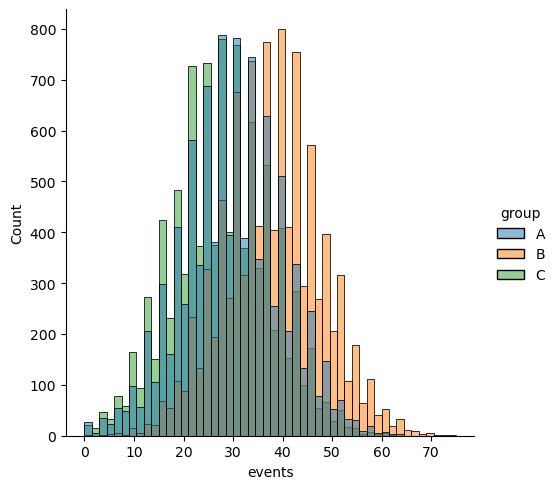

In [89]:
fig=plt.figure(figsize=(20,10), dpi=50)
sns.displot(data=task1_new, x='events', hue='group', bins=50)
plt.show()

<Figure size 1000x500 with 0 Axes>

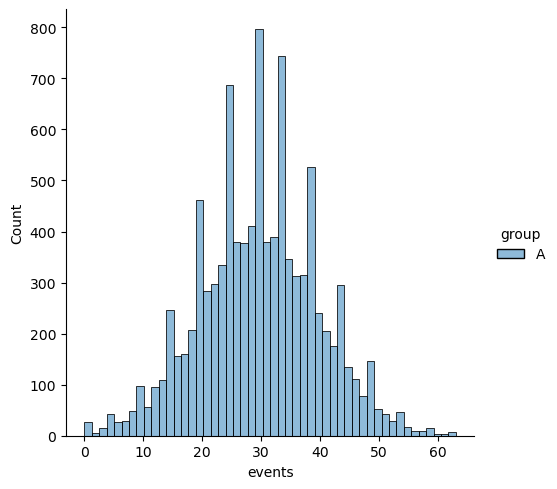

In [90]:
fig=plt.figure(figsize=(20,10), dpi=50)
sns.displot(data=task1_new[task1_new['group'] == 'A'], x='events', hue='group', bins=50)
plt.show()

<Figure size 1000x500 with 0 Axes>

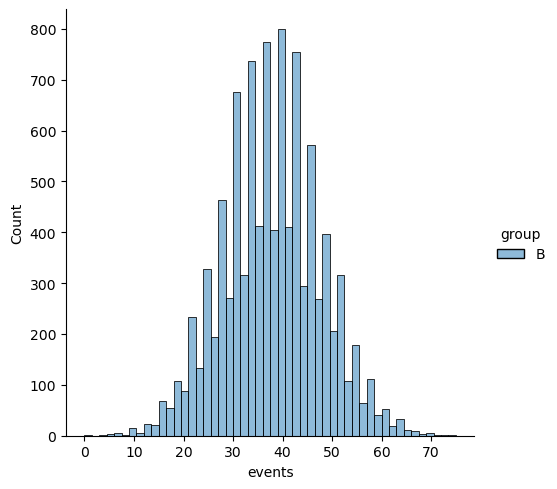

In [92]:
fig=plt.figure(figsize=(20,10), dpi=50)
sns.displot(data=task1_new[task1_new['group'] == 'B'], x='events', hue='group', bins=50)
plt.show()

<Figure size 1000x500 with 0 Axes>

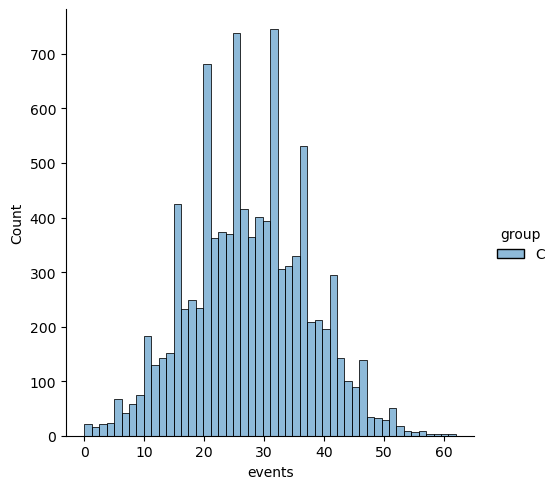

In [91]:
fig=plt.figure(figsize=(20,10), dpi=50)
sns.displot(data=task1_new[task1_new['group'] == 'C'], x='events', hue='group', bins=50)
plt.show()

в целом, данные всех групп распределены нормально

In [23]:
stats.shapiro(task1_new[task1_new['group'] == 'A'].events.values)

/Users/rrfeofanov/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9987682104110718, pvalue=6.104646104176936e-07)

используем тест Агостино-Пирсона для проверки нормальности для трех групп. Видим, что данные для двух групп распределены нормально, а для группы c - нет

In [24]:
pg.normality(data=task1_new, dv='events', group='group', method='normaltest', alpha=0.05)

,W,pval,normal
group,,,
A,0.793893,0.672370,True
B,0.841072,0.656695,True
C,16.064916,0.000325,False


In [25]:
pg.normality(data=task1_new, dv='events', group='group', method='jarque_bera', alpha=0.05)

,W,pval,normal
group,,,
A,0.821089,0.663289,True
B,0.820408,0.663515,True
C,14.518863,0.000704,False


смотрим нормально ли распределение по отдельности по каждой группе

In [35]:
scipy.stats.normaltest(task1_new[task1_new['group'] == 'A'].events.values)

NormaltestResult(statistic=0.7938927479944368, pvalue=0.6723700811857349)

In [36]:
scipy.stats.normaltest(task1_new[task1_new['group'] == 'B'].events.values)

NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)

In [37]:
scipy.stats.normaltest(task1_new[task1_new['group'] == 'C'].events.values)

NormaltestResult(statistic=16.06491584420947, pvalue=0.0003247490193567733)

Проверяем через qqplot с помощью statsmodels нормальность распределения каждой группы

<Figure size 1000x500 with 0 Axes>

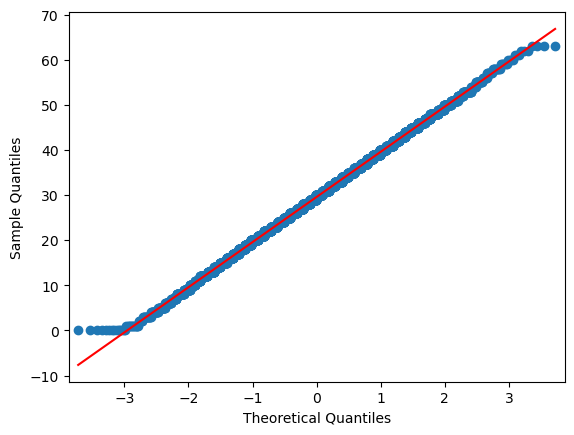

In [40]:
plt.fig = figure(figsize = (20,10), dpi=50)
sm.qqplot(task1_new[task1_new['group'] == 'A'].events.values, line='r')
plt.show()

<Figure size 1000x500 with 0 Axes>

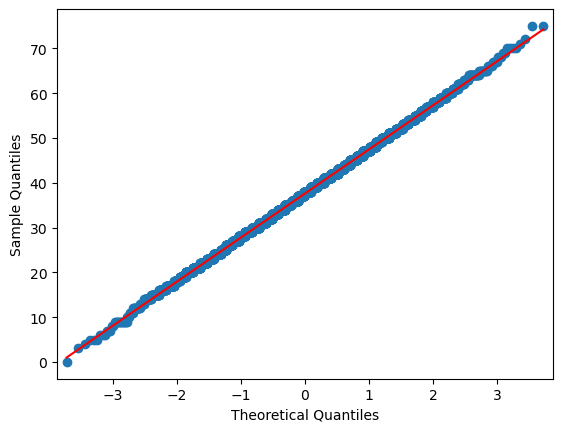

In [41]:
plt.fig = figure(figsize = (20,10), dpi=50)
sm.qqplot(task1_new[task1_new['group'] == 'B'].events.values, line='r')
plt.show()

<Figure size 1000x500 with 0 Axes>

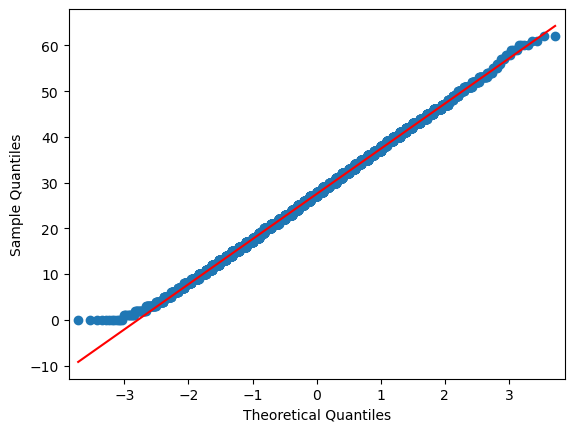

In [42]:
plt.fig = figure(figsize = (20,10), dpi=50)
sm.qqplot(task1_new[task1_new['group'] == 'C'].events.values, line='r')
plt.show()

В целом, данные распределены нормально. Проблема только в самом начале (много значений 0).

## 2) Проверьте, являются ли дисперсии внутри групп гомогенными.

Теперь проверим равенство дисперсий в группах (гомогенность дисперсии)

Проверяем с помощью критерия Levene из scipy. Дисперсии равны

In [44]:
levene(task1_new[task1_new['group'] == 'A'].events.values, task1_new[task1_new['group'] == 'B'].events.values, \
         task1_new[task1_new['group'] == 'C'].events.values)

LeveneResult(statistic=1.4116357313989074, pvalue=0.24376046615953575)

Проверяем с помощью levene из pinguin

In [45]:
pg.homoscedasticity(data=task1_new, dv='events', group='group', method='levene', alpha=0.05)

,W,pval,equal_var
levene,1.411636,0.24376,True


Проверяем с помощью bartlett из pinguin. Дисперсии равны

In [47]:
pg.homoscedasticity(data=task1_new, dv='events', group='group', method='bartlett', alpha=0.05)

,T,pval,equal_var
bartlett,3.27902,0.194075,True


Вывод: дисперсии трех групп равны. Данные в целом распределены нормально.

# Сравните средние в представленных группах

теперь проведем однофакторный дисперсионный анализ. Проверим есть ли отличия между средними наших групп
проверяем, есть ли хотя бы одно отличие между ними

проводим anova с помощью scipy. Видим, что хотя бы одно отличие между двумя группами есть

In [53]:
stats.f_oneway(task1_new[task1_new['group'] == 'A'].events.values, \
               task1_new[task1_new['group'] == 'B'].events.values, \
               task1_new[task1_new['group'] == 'C'].events.values)

F_onewayResult(statistic=2878.9899479893234, pvalue=0.0)

 спомощью statsmodels. Видим, что хотя бы одно отличие между двумя группами есть

In [55]:
model = smf.ols(formula = "task1_new['events'] ~ task1_new['group']", data = task1_new).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
task1_new['group'],2.0,5.659820e+05,282991.003793,2878.989948,0.0
Residual,29964.0,2.945319e+06,98.295239,NaN,NaN


с помощью pingouin. Видим, что хотя бы одно отличие между двумя группами есть

In [58]:
pg.anova(data=task1_new, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29964,2878.989948,0.0,0.161189


Итак, видим, что различия есть. Теперь проверим в каких именно группах с помощью попарного Т-теста и критерия Тьюки

## Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.

Но сначала с помощью критерия Бонферонни. В df около 30000 значений, поэтому очевидно, что тест покажет, что все группы значимо отличаются между собой

In [63]:
pg.pairwise_tests(data=task1_new, dv='events', between='group', padjust='holm', parametric=True)

/Users/rrfeofanov/opt/anaconda3/lib/python3.9/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)
/Users/rrfeofanov/opt/anaconda3/lib/python3.9/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-56.871776,19978.357800,two-sided,0.000000e+00,0.000000e+00,holm,inf,-0.804529
1,group,A,C,False,True,14.856336,19961.481317,two-sided,1.166166e-49,1.166166e-49,holm,6.802e+45,0.210265
2,group,B,C,False,True,72.253009,19977.508939,two-sided,0.000000e+00,0.000000e+00,holm,inf,1.022288


А теперь Тьюки. С помощью pinguin. И уже видно, что различия между вссеми группами.

In [65]:
pg.pairwise_tukey(data=task1_new, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.622109,37.613600,-7.991491,0.140256,-56.977752,0.0,-0.804529
1,A,C,29.622109,27.530461,2.091648,0.140327,14.905574,0.0,0.210265
2,B,C,37.613600,27.530461,10.083139,0.140281,71.878176,0.0,1.022288


Тьюки с помощью statsmodels. Различия есть между всеми группами

In [67]:
MultiComp = MultiComparison(task1_new.events, task1_new.group)

print(MultiComp.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B   7.9915   0.0   7.6628  8.3202   True
     A      C  -2.0916   0.0  -2.4205 -1.7627   True
     B      C -10.0831   0.0 -10.4119 -9.7543   True
----------------------------------------------------


применим т-тест gameshowell'а (если дисперсии не равны). Видим, что все равно средние групп различаются между собой

In [117]:
pg.pairwise_gameshowell(data=task1_new, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.622109,37.613600,-7.991491,0.140518,-56.871776,19978.357800,0.000000e+00,-0.804529
1,A,C,29.622109,27.530461,2.091648,0.140792,14.856336,19961.481317,9.030554e-13,0.210265
2,B,C,37.613600,27.530461,10.083139,0.139553,72.253009,19977.508939,0.000000e+00,1.022288


Как видно по последней колонке, все нулевые гипотезы были отклонены, поэтому мы делаем вывод,
что средние всех трёх групп значимо различаются.

## Примите решение: какие картинки в итоге будем использовать?

А теперь определим какие картинки использовать с помощью barplota и pointplota. Будем использовать ту форму картинки, при которой было больше всего заказов

Text(0, 0.5, 'заказы')

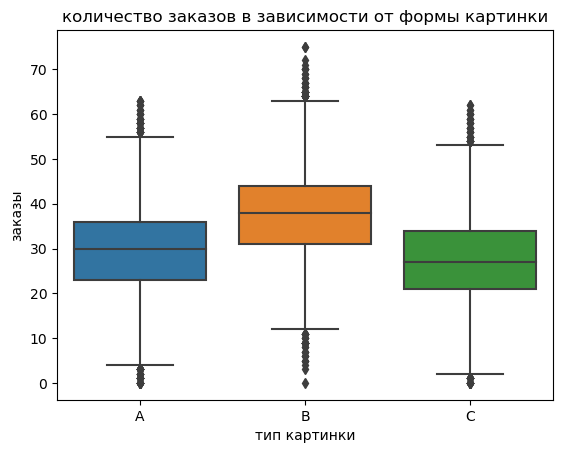

In [78]:
sns.boxplot(x = 'group', y = 'events', data = task1_new)
plt.title('количество заказов в зависимости от формы картинки')
plt.xlabel('тип картинки')
plt.ylabel('заказы')

Text(0, 0.5, 'заказы')

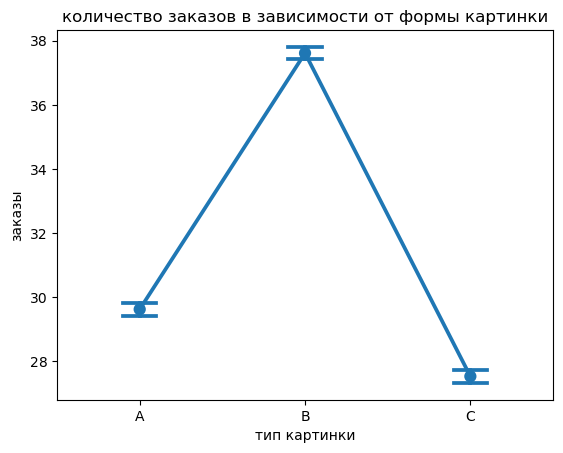

In [80]:
sns.pointplot(x = 'group', y = 'events', data = task1_new, capsize = .2)
plt.title('количество заказов в зависимости от формы картинки')
plt.xlabel('тип картинки')
plt.ylabel('заказы')

Вывод: видим, что заказов больше у формы картинки B (квадратные)

## Задание 2
## Выберите метод для второго теста.  


Продублируем данные:

- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

Проверим данные на наличие пропущенных значений и соответствие типов

In [30]:
task2.head(5)

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [81]:
task2.describe()

,id,events
count,100000.000000,100000.000000
mean,49999.500000,34.213930
std,28867.657797,17.585193
min,0.000000,4.000000
25%,24999.750000,21.000000
50%,49999.500000,29.000000
75%,74999.250000,40.000000
max,99999.000000,102.000000


In [82]:
task2.isna().any()

id         False
group      False
segment    False
events     False
dtype: bool

In [83]:
task2.dtypes

id           int64
group       object
segment     object
events     float64
dtype: object

In [84]:
task2.shape

(100000, 4)

C данными все хорошо

## Визуализируйте распределение events для контрольной и тестовой групп. 

Посмотрим распределение на графике у control group

Из графиков видно, что данные в разрезе групп распределены не нормально. Можно посмотреть данные отдельно по сегментам

<Figure size 1000x500 with 0 Axes>

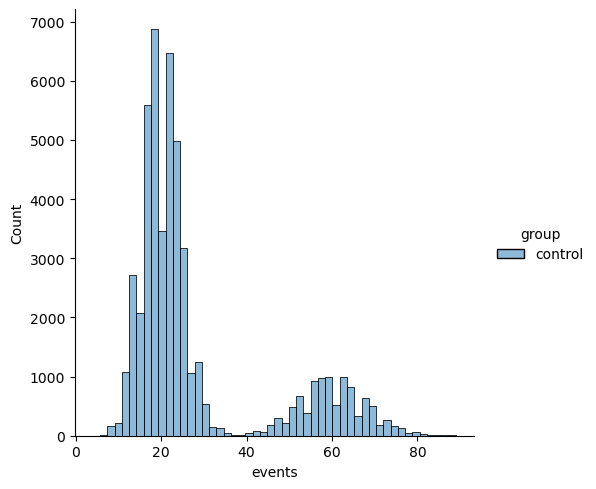

In [96]:
fig=plt.figure(figsize=(20,10), dpi=50)
sns.displot(data=task2[task2['group'] == 'control'], x='events', hue='group', bins=50)
plt.show()

<Figure size 1000x500 with 0 Axes>

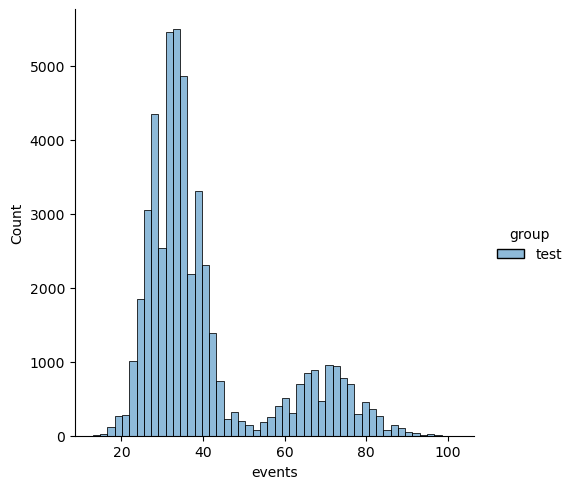

In [95]:
fig=plt.figure(figsize=(20,10), dpi=50)
sns.displot(data=task2[task2['group'] == 'test'], x='events', hue='group', bins=50)
plt.show()

  В сегменте low данные распределены не нормально, а в сегменте high на первый взгляд - нормально  

<Figure size 1000x500 with 0 Axes>

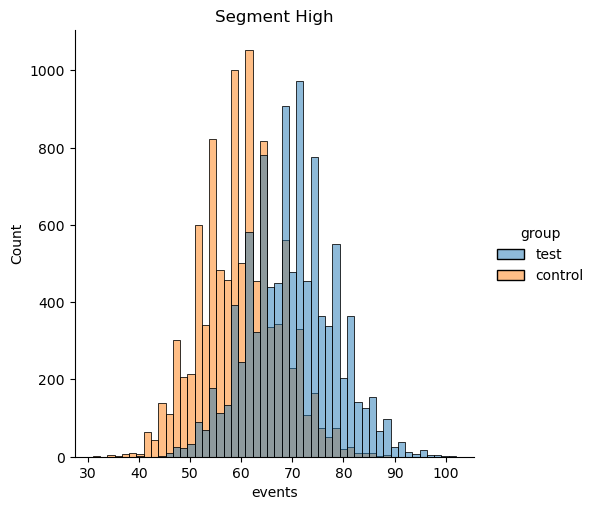

In [149]:
fig=plt.figure(figsize=(20,10), dpi=50)
sns.displot(data=task2.query("segment == 'high'"), x='events', hue='group', bins=50)
plt.title('Segment High')
plt.show()

<Figure size 1000x500 with 0 Axes>

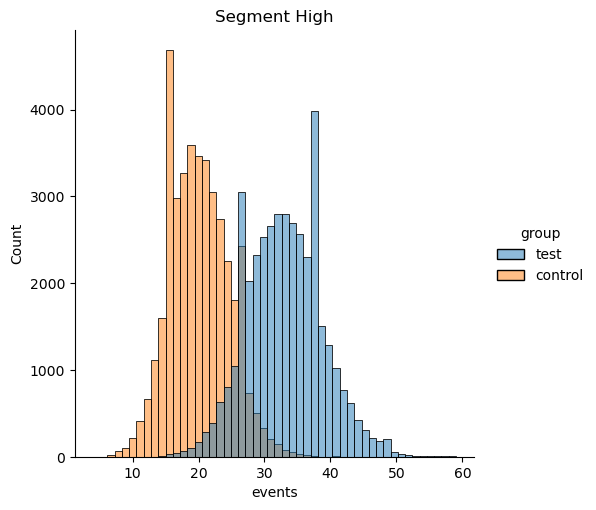

In [148]:
fig=plt.figure(figsize=(20,10), dpi=50)
sns.displot(data=task2.query("segment == 'low'"), x='events', hue='group', bins=50)
plt.title('Segment High')
plt.show()

## Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя

считаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя

In [118]:
task2.groupby(['group', 'segment']).agg({'events':['mean', 'median', 'std']})

events                 
                      mean median       std
group   segment                            
control high     59.970800   60.0  7.805347
        low      20.031575   20.0  4.473576
test    high     69.938500   70.0  8.403974
        low      33.025925   33.0  5.720845

In [119]:
task2.groupby(['group', 'segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

проверим нормальность распределения данных с помощью теста Агостино-Пирсона. Везде распределение ненормальное

In [104]:
pg.normality(data=task2, dv='events', group='segment', method='normaltest', alpha=0.05)

,W,pval,normal
segment,,,
high,97.557119,6.542456e-22,False
low,4859.376919,0.000000e+00,False


в сегменте low распределение сильно отклоняется от нормального, как было видно по графику

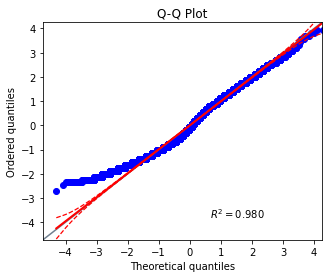

In [89]:
pg.qqplot(task2[task2['segment'] == 'low'].events)

А в сегменте high распределение совсем немного отклоняется от нормального

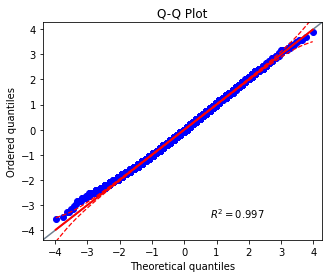

In [99]:
pg.qqplot(task2[task2['segment'] == 'high'].events)

теперь проверяем гомогенность дисперсии.  
у контрольной и тестовой групп она не отличается

In [101]:
pg.homoscedasticity(data=task2, dv='events', group='group', method='levene', alpha=0.05)

,W,pval,equal_var
levene,2.544005,0.110717,True


у сегментов она отличается

In [103]:
pg.homoscedasticity(data=task2, dv='events', group='segment', method='levene', alpha=0.05)

,W,pval,equal_var
levene,335.193107,9.423048e-75,False


## Выберите формулу для модели, проведите тест.

Так как факторов больше, чем один (их два: тип сегмента и тип группы), то применяем two-way anova (двухфакторный дисперсионный анализ), чтобы понять, есть ли у нас значимые различия между любыми двумя группами

перейдем к расчету многофакторного дисперсионного анализа, используя statsmodels

In [109]:
formula = 'events ~ group + segment + group:segment'
model = ols(formula, task2).fit()
aov_table = anova_lm(model, typ=2)

Из дисперсионного анализа видно, что есть различия между какими-либо двумя группами по двум факторам и по взаимодействию этих факторов

In [110]:
# смотрим результаты анализа
aov_table

,sum_sq,df,F,PR(>F)
group,3.837195e+06,1.0,112031.864120,0.000000e+00
segment,2.362480e+07,1.0,689756.377485,0.000000e+00
group:segment,3.664244e+04,1.0,1069.823274,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


многофакторный дисперсионный анализ, используя pg

In [111]:
pg.anova(data=task2, dv="events", between=["group", "segment"])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864120,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377485,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823274,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


Различия есть. Осталось определить между какими группами есть различия

Создаем новую колонку, в которой указваем, какая именно группа у каждого id


In [151]:
task2['combination'] = task2['group'] + '\\' + task2['segment']

In [152]:
task2

,id,group,segment,events,combination
0,83440,test,high,78.0,test\high
1,96723,test,high,71.0,test\high
2,68719,test,high,80.0,test\high
3,50399,test,high,80.0,test\high
4,95613,test,high,78.0,test\high
...,...,...,...,...,...
99995,60695,control,low,15.0,control\low
99996,5934,control,low,16.0,control\low
99997,30046,control,low,22.0,control\low
99998,26474,control,low,21.0,control\low


проводим Т-тест с критерием Тьюки (менее консервативен, чем критерий Бонферони)  
проводится так же как и для однофакторного анализа, так как передаем в аргумент колонку с названием-комбинацией

In [153]:
pg.pairwise_tukey(data=task2, dv="events", between="combination")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control\high,control\low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,7.521612
1,control\high,test\high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.228989
2,control\high,test\low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.350026
3,control\low,test\high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-9.091140
4,control\low,test\low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.530414
5,test\high,test\low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,5.814008


Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой
Разница между control/high и test/high составила около 10
Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13

Посмотрим на боксплот

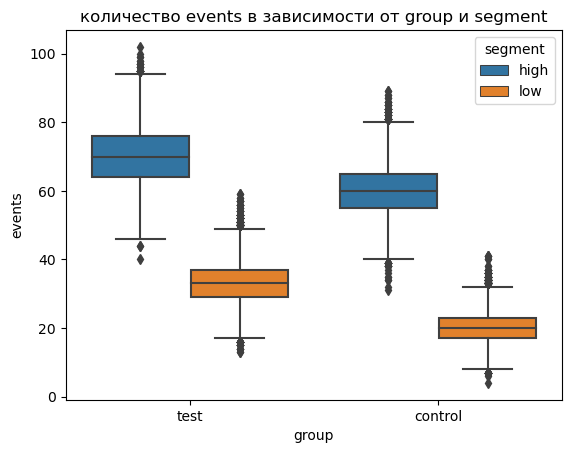

In [115]:
sns.boxplot(x = 'group', y = 'events', hue = 'segment', data = task2)
plt.title('количество events в зависимости от group и segment')
plt.xlabel('group')
plt.ylabel('events')
plt.legend(title = 'segment')

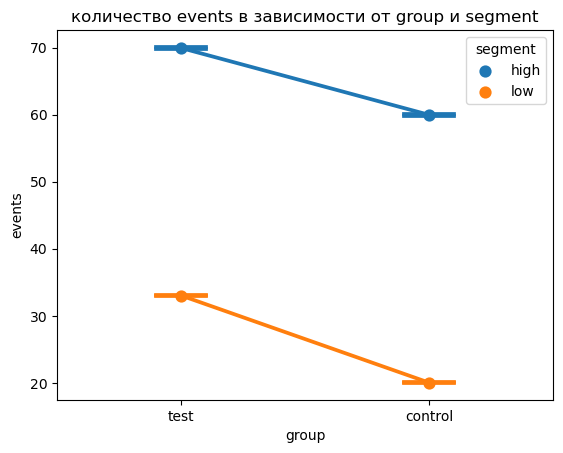

In [116]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = task2, capsize = .2)
plt.title('количество events в зависимости от group и segment')
plt.xlabel('group')
plt.ylabel('events')
plt.legend(title = 'segment')

Вывод: видим, что среднее значение в тестовой группе для обоих сегментов увеличилось. Значит выкатываем новое обновление.